In this competition, we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

Let's go over the dataset we will be working on.
In technical terms, we are using medical images and classifying whether an image contains cancer metastasis or not.
The data provided to us consists images and the respective labels in the metadata. The metadata contains information on whether the scan contains cancer cells.

Of course, there are several sets.
A larger one for training and smaller ones for testing and validation. 

EDA: Basic information about the data

In [11]:
import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf_keras

import tensorflow

from tensorflow import keras

from keras import datasets, layers, models, preprocessing


test_path = './data/test/'
train_path = './data/train/'
train_data = pd.read_csv('./data/train_labels.csv')
print("Sample")
print(train_data["id"].head(3))

train_data.info()
print("")
print(train_data.head())
print("")
print(train_data.describe())
print("")
print(len(os.listdir(test_path)))



Sample
0    f38a6374c348f90b587e046aac6079959adf3835
1    c18f2d887b7ae4f6742ee445113fa1aef383ed77
2    755db6279dae599ebb4d39a9123cce439965282d
Name: id, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

57458


An example of data showing tumors.

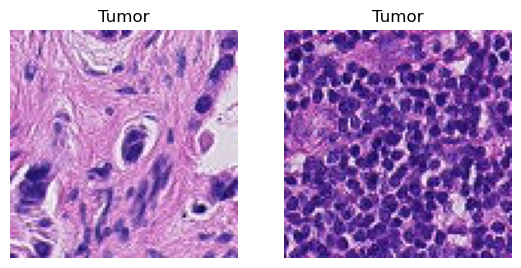

In [12]:
train_data = pd.read_csv('./data/train_labels.csv')

sample_tumor_ids = train_data[train_data["label"] == 1]['id'].sample(2).values


tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumor_images.append(Image.open(image_path))
    
    
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()




An example of healthy cells.

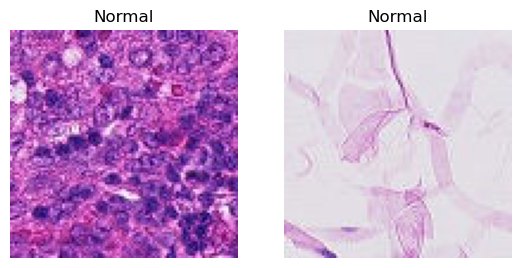

In [13]:
train_data = pd.read_csv('./data/train_labels.csv')

sample_normal_ids = train_data[train_data["label"] == 0]['id'].sample(2).values


normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    normal_images.append(Image.open(image_path))

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal')
    plt.axis('off')
plt.show()

Correlation of cancerous images to healthy ones: (where 1 is tumor)

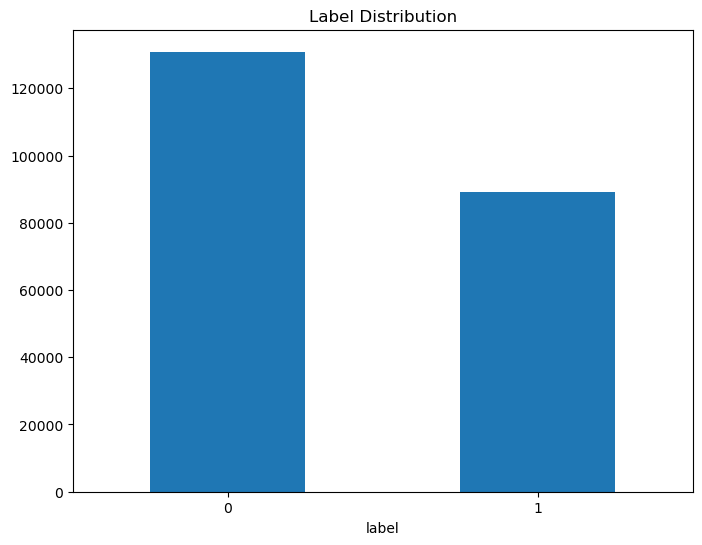

In [14]:
# get count
label_counts = train_data['label'].value_counts()

# histogram
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xticks(rotation=0)

plt.show()

Preparing code for data generators for the upcoming models + normalizing images with rescaling (divide each pixel value by 255)

In [15]:


# Assuming train_path is defined and contains the path to the directory
# Ensure train_path does not have trailing slashes
# Ensure train_path is defined correctly
train_path = train_path.rstrip('/')
train_data = pd.read_csv('./data/train_labels.csv')

# Modify the "id" column to include the full path
train_data["id"] = train_data["id"].apply(lambda x: os.path.join(f"{x}.tif"))

# Convert the "label" column to string type
train_data["label"] = train_data["label"].astype(str)


# Print the first 3 elements to verify the paths
# print(train_data["id"].head(3))

# Initialize the ImageDataGenerator with rescaling and validation split
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

# Create the training data generator with the correct directory
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,  # Specify the directory without trailing slash
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    class_mode="binary",
    target_size=(32,32),
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    class_mode="binary",
    target_size=(32,32))






Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Model 1: Baseline Model This will be a baseline CNN model with basic architecture:

Architecture: Input → Conv2D (filter=16) → Conv2D (filter=16) → MaxPool → Conv2D (filter=32) → Conv2D (filter=32) → AveragePool → Global Average pooling → Dense → Output (Sigmoid) (suitable for binary classification)


In [16]:
model1 = models.Sequential()
    
model1.add(layers.Conv2D(filters=16, kernel_size=(3,3)))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))

model1.add(layers.Conv2D(filters=32, kernel_size=(3,3)))
model1.add(layers.AveragePooling2D(pool_size=(2,2)))

#model1.add(layers.Flatten())

model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(1, activation='sigmoid'))
    
model1.build(input_shape=(32, 64, 64, 3))
    
model1.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (32, 62, 62, 16)       │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 31, 31, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 29, 29, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (32, 14, 14, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (32, 32)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
his_model1 = model1.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5


c:\Users\gofma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


687/687 ━━━━━━━━━━━━━━━━━━━━ 79s 114ms/step - accuracy: 0.6718 - loss: 0.6122 - val_accuracy: 0.7269 - val_loss: 0.5760
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.6914 - loss: 0.5906 - val_accuracy: 0.6725 - val_loss: 0.6150
Epoch 3/5


c:\Users\gofma\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


687/687 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.7195 - loss: 0.5744 - val_accuracy: 0.7047 - val_loss: 0.5777
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.7188 - loss: 0.5515 - val_accuracy: 0.7424 - val_loss: 0.5863
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.7233 - loss: 0.5689 - val_accuracy: 0.7002 - val_loss: 0.5796


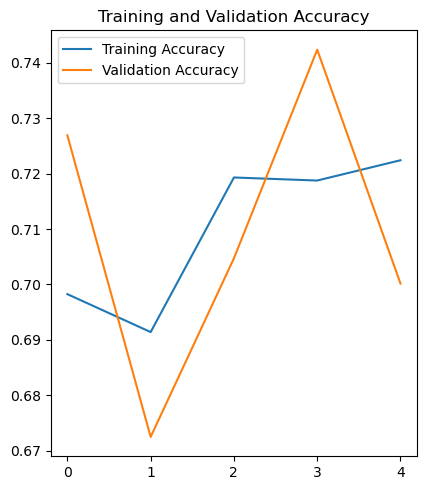

In [18]:
acc = his_model1.history['accuracy']
val_acc = his_model1.history['val_accuracy']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()



plt.tight_layout()
plt.show()

Optimizing and complicating the model.
To Optimize the current model we will add hyperparameter tuning.

In [19]:
from keras import optimizers
import keras_tuner as kt

def model_builder(hp):
    model1 = models.Sequential()

    # Convolutional layer 1
    model1.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(hp.Choice('conv1_kernel_height', values=[3, 5]), hp.Choice('conv1_kernel_width', values=[3, 5])),
        activation='relu',
        input_shape=(64, 64, 3)
    ))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer 2
    model1.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(hp.Choice('conv2_kernel_height', values=[3, 5]), hp.Choice('conv2_kernel_width', values=[3, 5])),
        activation='relu'
    ))
    model1.add(layers.AveragePooling2D(pool_size=(2, 2)))

    # GlobalAveragePooling2D layer
    model1.add(layers.GlobalAveragePooling2D())

    # Dense layer
    model1.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model1.compile(
        optimizer=optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model1

# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)


# Run the hyperparameter search
tuner.search(
    train_generator,
    steps_per_epoch=687,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=171,
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_model.summary()

bestModelHist = best_model.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)


Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json


c:\Users\gofma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\gofma\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 27, 128)    │        92,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 13, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,761 (366.25 KB)

 Trainable params: 93,761 (366.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 90s 130ms/step - accuracy: 0.7923 - loss: 0.4571 - val_accuracy: 0.7974 - val_loss: 0.4496
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.8359 - loss: 0.4131 - val_accuracy: 0.7991 - val_loss: 0.4257
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 128s 185ms/step - accuracy: 0.7964 - loss: 0.4480 - val_accuracy: 0.8030 - val_loss: 0.4395
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.8008 - loss: 0.4399 - val_accuracy: 0.8253 - val_loss: 0.4756
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 89s 129ms/step - accuracy: 0.8024 - loss: 0.4398 - val_accuracy: 0.8012 - val_loss: 0.4357


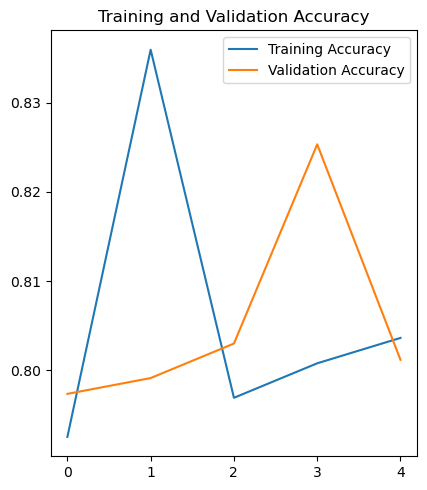

In [20]:
acc = bestModelHist.history['accuracy']
val_acc = bestModelHist.history['val_accuracy']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()



plt.tight_layout()
plt.show()

Comparing accuracy for the model with HyperTuning without.
As you can see, both of the charts have the same behaviour patterns over epochs. Howeever, The hypertuned model has the same features with higher accuracy.

Some observations:
Both the training and validation accuracies exhibit a similar pattern of sharp increase, peak, and then drop.
The drop in the third epoch suggests that the model may have encountered some overfitting or variance issues during that period.

These observations largly imply that that the model may benefit from additional tuning, such as adjusting the learning rate, using regularization techniques, or perhaps increasing the amount of training data.

Trying another approach, and using a pretrained model.
I explored transfer learning by leveraging the VGG16 model pre-trained on ImageNet.
This model architecture is slightly different then our previous CNN, however, it should fit the goals well.

In [21]:

from keras import applications
# Load the VGG16 model with weights pre-trained on ImageNet
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

his_modelAdvanced = model.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 267s 386ms/step - accuracy: 0.6646 - loss: 0.6021 - val_accuracy: 0.7525 - val_loss: 0.5102
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.7188 - loss: 0.5395 - val_accuracy: 0.7249 - val_loss: 0.5197
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 358s 521ms/step - accuracy: 0.7499 - loss: 0.5112 - val_accuracy: 0.7651 - val_loss: 0.4889
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8086 - loss: 0.4431 - val_accuracy: 0.7991 - val_loss: 0.4441
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 285s 414ms/step - accuracy: 0.7635 - loss: 0.4894 - val_accuracy: 0.7717 - val_loss: 0.4770


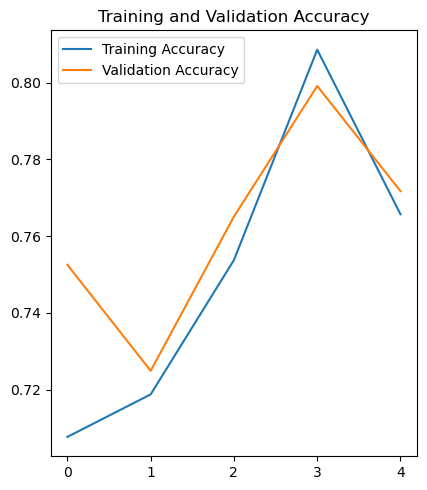

In [22]:
# Plotting training and validation loss and accuracy
acc = his_modelAdvanced.history['accuracy']
val_acc = his_modelAdvanced.history['val_accuracy']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()



plt.tight_layout()
plt.show()

We have tried multiple techniques, experimented with pretrained models and hyperparameter tuning to increase preformance.

Result Analysis: 
The CNN + hypertuning model we created and the used pretrained model showed excellent results, however, their training patters differ.
I would prefer using the pretrained model as it is convenient and predictable when Training and Validaton accuracy behave in a similiar pattern. 

However, there are some things that could be improved. For example, we could try to further enhance the regularization on all of our models to counter risks of overfitting.
We would also benefit from a larger number of epochs and larger training datasets.

